### Ultimate Data Science Challenge

#### Exploratory data analysis

We are given a file containing timestamps of user logins in a particular location and we need to find interesting patterns in the resulting time series that characterize the underlying demand.

In [2]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
# Load json
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


There are 93412 recorded logins, some of them are duplicates as unique logins are only 92265. We will just aggregate these up for every user. 

We first look at 15 minute intervals aggregated across the full time interval between 1st of Jan and 13th of April

In [44]:
# Set index of the date frame for full timestamp
logins_v = logins
logins_v['visited'] = 1
logins_idx = logins_v.set_index(pd.DatetimeIndex(pd.to_datetime(logins_v.login_time))).drop('login_time', axis=1)

# Resample the index for 15min increments
logins_15min = logins_idx.resample('15T').sum().fillna(0)
logins_15min['val_time'] = pd.Series(logins_15min.index.values).dt.time.values

# Group by time of day
logins_15min_agg = logins_15min.groupby('val_time', as_index=True).sum()
logins_15min_agg.head()

,visited
val_time,
00:00:00,1439
00:15:00,1547
00:30:00,1525
00:45:00,1482
01:00:00,1549


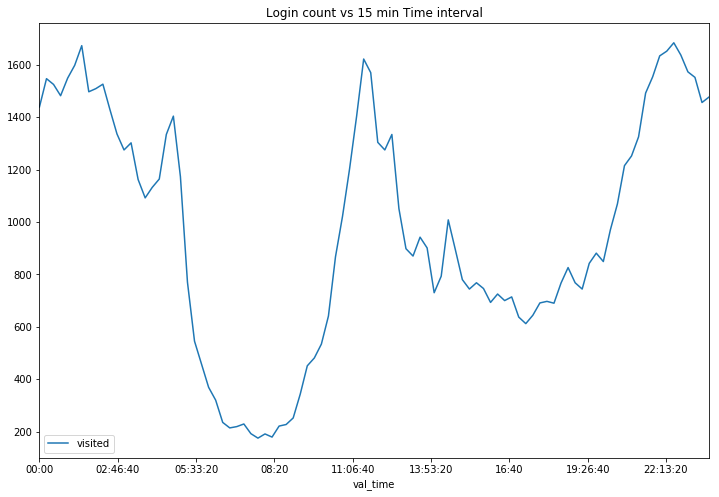

In [45]:
logins_15min_agg.plot(figsize=(12, 8), title='Login count vs 15 min Time interval')

Looking at the plot we see that the login traffic drops in the morning when most people are heading out to work or busy with morning activities and in the evening commute time around 5:00 pm. The activity peaks during lunchtime around 12 pm and after dinner between 10:30 pm to 1:30 pm.

Next lets look at the day of the week for some patterns.

In [50]:
# Resample the index for day of the week increments
logins_15min_dow = logins_15min
logins_15min_dow['day_of_week'] = pd.Series(logins_15min.index.values).dt.dayofweek.values

# Group by time of day
logins_15min_dow_agg = logins_15min_dow.groupby(['val_time', 'day_of_week'], as_index=False).sum()
logins_15min_dow_agg.head()

,val_time,day_of_week,visited
0,00:00:00,0,126
1,00:00:00,1,147
2,00:00:00,2,158
3,00:00:00,3,214
4,00:00:00,4,237


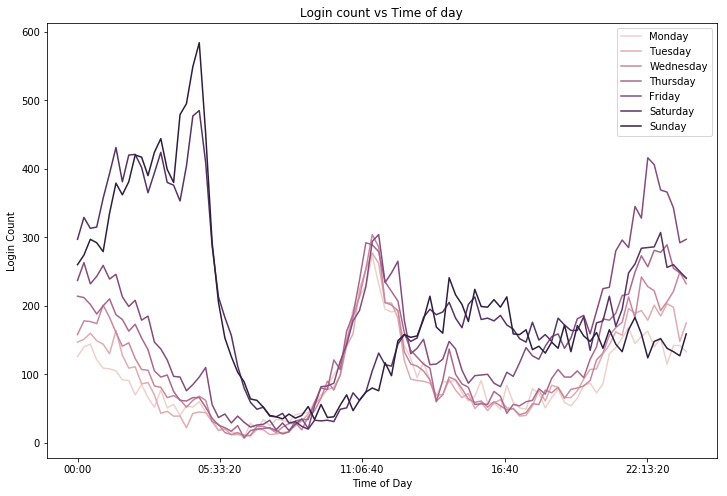

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sns.lineplot('val_time', 'visited', hue='day_of_week', data=logins_15min_dow_agg)
_ = plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
_ = plt.title('Login count vs Time of day')
_ = plt.xlabel('Time of Day')
_ = plt.ylabel('Login Count')

We see another interesting pattern here. Users tend to logon early hours of the weekend but not so much during the day. For weekdays, the usage is much lesser after midnight but tends to peak earlier in the evenings and during lunchtime.

#### Experiment Design Question

Two neighboring cities have complementary traffic patterns. One is active during day and other during night. To encourage driver partners to be available in both cities two-way tolls are re-imbursed.

A good metric to evaluate the effectiveness of reimbursement policy is to take the difference in means of number of available driver partners (or alternatively customer waiting times) with and without the policy for each city.

A practical experiment to verify this metric would be as follows:
* Get multiple Random samples of drivers in each city. $R_g$ for Gotham and $R_m$ for Metropolis. 
* Divide all of the two groups further evenly as treatment and control. Reimburse toll costs for treatments.
* There will be four different means we calculate:
    - In Gotham:
        - Take a difference of means of drivers from Gotham for treatment vs control group.
        - Take a difference of means of drivers from Metropolis for treatment vs control group.
    - Similarly in Metropolis:
        - Difference of means of drivers from Gotham for treatment vs control group.
        - Difference of means of drivers from Metropolis for treatment vs control group.
* Repeat the above for different times of day.

The null hypothesis is that there is no difference in means for treatment vs control across towns and times. The alternative hypothesis is that there is a difference in means.

A significance level is picked, say 5% and the hypothesis is checked against the drawn samples for reaching a conclusion.

#### Predictive Modeling - User Retention

A sample dataset for a cohort of users for trips taken is given. The goal of the model is predict whether a user will take at least one trip in a 30 day interval and understand the most important predictors for that.

In [59]:
# Load the data
with open('ultimate_data_challenge.json') as f:
   e_json = json.load(f)

engagement = pd.DataFrame(e_json)
engagement.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [60]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We see that some of the rows have few values missing such as average rating by/of driver and the type of phone. Dropping average rating of driver null values loses about a fifth of the dataset. To prevent that we will impute missing values with mean for both average rating by/of driver. For phone, we just add a categorical variable called 'UNKNOWN'.

In [75]:
# Impute missing values
eng_clean = engagement
eng_clean['avg_rating_by_driver'] = eng_clean.avg_rating_by_driver.fillna(eng_clean.avg_rating_by_driver.mean())
eng_clean['avg_rating_of_driver'] = eng_clean.avg_rating_of_driver.fillna(eng_clean.avg_rating_of_driver.mean())
eng_clean['phone'] = eng_clean.phone.fillna('UNKNOWN')
eng_clean['signup_date'] = pd.to_datetime(eng_clean.signup_date)
eng_clean['last_trip_date'] = pd.to_datetime(eng_clean.last_trip_date)

eng_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Next we build the response variable column 'y', to find users that are active in the 6th month, that is, made at least one trip in the 6th month.

In [91]:
# Function to build response variable
def get_y(row):
    signup = row['signup_date']
    start = signup + pd.DateOffset(months = 5)
    end = signup + pd.DateOffset(months = 6)
    last = row['last_trip_date']
    if last > start and last <= end:
        return True
    else:
        return False

y = eng_clean.apply(get_y, axis=1)

In [93]:
print('Number of users that are active in 6th month: {0}'.format(np.sum(y)))

Number of users that are active in 6th month: 11711


Next we build the feature matrix. Here we need to one-hot encode all the categorical columns.

In [97]:
# One hot encode categorical columns
X_start = eng_clean[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                     'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']]

X_cat = pd.get_dummies(eng_clean[['city', 'phone', 'ultimate_black_user']])

X = pd.concat([X_start, X_cat], axis=1)
X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_UNKNOWN,phone_iPhone
0,3.67,5.0,5.0,1.10,15.4,4,46.2,True,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,False,1,0,0,1,0,0
2,0.77,5.0,5.0,1.00,0.0,3,100.0,False,1,0,0,0,0,1
3,2.36,4.9,4.9,1.14,20.0,9,80.0,True,0,1,0,0,0,1
4,3.13,4.9,4.9,1.19,11.8,14,82.4,False,0,0,1,1,0,0


Since this is a classification problem we use a simple Logistic Regression classifier for classification. First we split data in train/test sets and then use K-Fold crossvalidation to decide on Regularization Parameter.

In [98]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Hyper-parameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#the grid of parameters to search over
Cs = [0.001, 0.1, 1., 10.]

parameters = {'C':Cs}

clf = LogisticRegression(solver='liblinear')

cv_grid = GridSearchCV(clf, parameters, cv=5, scoring=make_scorer(accuracy_score), iid=True)
cv_grid.fit(X_train, y_train)
print(cv_grid.best_params_, cv_grid.best_score_)
print(accuracy_score(cv_grid.predict(X_test), y_test))

{'C': 0.1} 0.7762857142857142
0.7768


#### Best Parameters for Logistic Regression

In [100]:
# Get Best Estimator Coefficients
cv_grid.best_estimator_.coef_

array([[-3.84028519e-02, -7.08556746e-02, -7.08556746e-02,
        -1.66506354e-01,  4.80314647e-03,  9.73946758e-02,
        -4.07052806e-04,  6.82457636e-01, -7.44063612e-01,
         4.51504054e-01, -2.45313554e-01, -6.22427141e-01,
        -2.45441414e-01,  3.29995444e-01]])

In [101]:
lr_best_params = dict(zip(X.columns.tolist(), cv_grid.best_estimator_.coef_[0].tolist()))
lr_best_params_s = sorted(lr_best_params, key=lambda x: abs(lr_best_params[x]), reverse=True)
pd.DataFrame({'feature_name': lr_best_params_s, 'feature_coeff': [lr_best_params[i] for i in lr_best_params_s]}).head(50)

,feature_name,feature_coeff
0,city_Astapor,-0.744064
1,ultimate_black_user,0.682458
2,phone_Android,-0.622427
3,city_King's Landing,0.451504
4,phone_iPhone,0.329995
5,phone_UNKNOWN,-0.245441
6,city_Winterfell,-0.245314
7,avg_surge,-0.166506
8,trips_in_first_30_days,0.097395
9,avg_rating_by_driver,-0.070856


Some insights that we get are:
* We see that users from Astapor or using Android are not inclined to be retained for a long time. 
* In addition, we see that users taking 'Ultimate Black' in the first 30 days are very likely to be active.  
* Users from Kings Landing and using iphone are likely to be active.
* Users taking trips in 30 days are likely to be active later.

Some actionable policies to improve user retention:
* Investigate why location is playing such a important role in usage. Investigate causes such as driver partner availability, traffic patterns, quality of trips etc. for low retention in Astapor.
* Improve mobile app experience for Android phones.
* Engage users who have not travelled in first 30 days by sending them emails or offers.